In [3]:
import gym

import numpy as np
import pandas as pd
import pathlib

from IPython.core.pylabtools import figsize
from tqdm.notebook import tqdm
import itertools

from lcs import Perception


import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

# Import common utils code
%run utils/experiments.py
%run utils/bayes.py

In [4]:
cache_prefix = f'{pathlib.Path().absolute()}/cache/'
cache_prefix

'/home/arc/Projects/pwr/pyalcs-experiments/notebooks/publications/latent-learning-for-anticipatory-classifier-systems-in-discretized-real-valued-environments/cache/'

## Compute populations
All algorithms will be run one more time to create a final list of population

In [8]:
%%time

# LCS helpers
def corridor_knowledge(pop, env):
    transitions = env.env.get_transitions()
    reliable = [c for c in pop if c.is_reliable()]
    nr_correct = 0

    for start, action, end in transitions:
        p0 = Perception((str(start),))
        p1 = Perception((str(end),))

        if any(
                [True for cl in reliable if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1

    return nr_correct / len(transitions)


def corridor_metrics_collect(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': corridor_knowledge(population, env),
        'generalization': generalization_score(population)
    }


class CorridorObservationWrapper(gym.ObservationWrapper):
    def observation(self, observation):
        return observation,


def run_corridor(trials_explore, trials_exploit):
    # noinspection PyUnresolvedReferences
    import gym_corridor

    corridor = gym.make('corridor-20-v0')

    # DynaQ helpers
    def dynaq_corridor_knowledge_calculator(model, env):
        transitions = env.env.get_transitions()
        nr_correct = 0

        for (s0, a, s1) in transitions:
            if s0 in model and a in model[s0] and model[s0][a][0] == s1:
                nr_correct += 1

        return nr_correct / len(transitions)


    common_params = {
        'env': corridor,
        'observation_wrapper': CorridorObservationWrapper,
        'classifier_length': 1,
        'possible_actions': 2,
        'learning_rate': 0.1,
        'metrics_trial_freq': 1,
        'metrics_fcn': corridor_metrics_collect,
        'trials': trials_explore
    }

    acs_params = {}
    acs2_params = {'do_ga': False, 'initial_q': 0.5}
    acs2_oiq_params = {'do_ga': False, 'initial_q': 0.8}
    acs2_ga_params = {'do_ga': True, 'initial_q': 0.5}
    acs2_ga_oiq_params = {'do_ga': True, 'initial_q': 0.8}

    yacs_params = {
        'trace_length': 3,
        'estimate_expected_improvements': False,
        'feature_possible_values': [set(str(i) for i in range(19)),]
    }

    dynaq_params = {
        'q_init': np.zeros((corridor.env.observation_space.n, 2)),
        'model_init': {},
        'perception_to_state_mapper': lambda p: int(p),
        'knowledge_fcn': dynaq_corridor_knowledge_calculator,
        'epsilon': 0.5
    }

    # explore phase
    explore_result = run_experiment_parallel(common_params,
                                             acs_params=acs_params,
                                             acs2_params=acs2_params,
                                             acs2_oiq_params=acs2_oiq_params,
                                             acs2_ga_params=acs2_ga_params,
                                             acs2_ga_oiq_params=acs2_ga_oiq_params,
                                             yacs_params=yacs_params,
                                             dynaq_params=dynaq_params)

    # exploit phase
    common_params['trials'] = trials_exploit
    acs_params['init_population'] = explore_result[0]['acs'].get_population()

    acs2_params['init_population'] = explore_result[0]['acs2'].get_population()
    acs2_oiq_params['init_population'] = explore_result[0]['acs2_oiq'].get_population()
    acs2_ga_params['init_population'] = explore_result[0]['acs2_ga'].get_population()
    acs2_ga_oiq_params['init_population'] = explore_result[0]['acs2_ga_oiq'].get_population()

    yacs_params['init_population'] = explore_result[0]['yacs'].get_population()
    yacs_params['init_desirability_values'] = explore_result[0]['yacs'].desirability_values

    dynaq_params['q_init'] = explore_result[0]['dynaq'][0]
    dynaq_params['model_init'] = explore_result[0]['dynaq'][1]
    dynaq_params['epsilon'] = 1.0

    exploit_result = run_experiment_parallel(common_params,
                                             acs_params=acs_params,
                                             acs2_params=acs2_params,
                                             acs2_oiq_params=acs2_oiq_params,
                                             acs2_ga_params=acs2_ga_params,
                                             acs2_ga_oiq_params=acs2_ga_oiq_params,
                                             yacs_params=yacs_params,
                                             dynaq_params=dynaq_params)

    return explore_result, exploit_result

CPU times: user 48 µs, sys: 0 ns, total: 48 µs
Wall time: 50.5 µs


In [12]:
df = pd.DataFrame(columns=['agent', 'trial_steps'])

for i in tqdm(range(0, 20), desc='Run'):
    _, exploit_output = run_corridor(300, 25)
    metrics_df = exploit_output[1].reset_index()
    df = pd.concat([df, metrics_df[['agent', 'trial_steps']]])

Run: 100%|██████████| 20/20 [06:40<00:00, 20.01s/it]


# Bayesian estimation of performance

The null hypothesis is that the performance of two classifiers is practically the same. To either accept or reject it the  ROPE and HDI intervals will be used.

## Go with all combinations

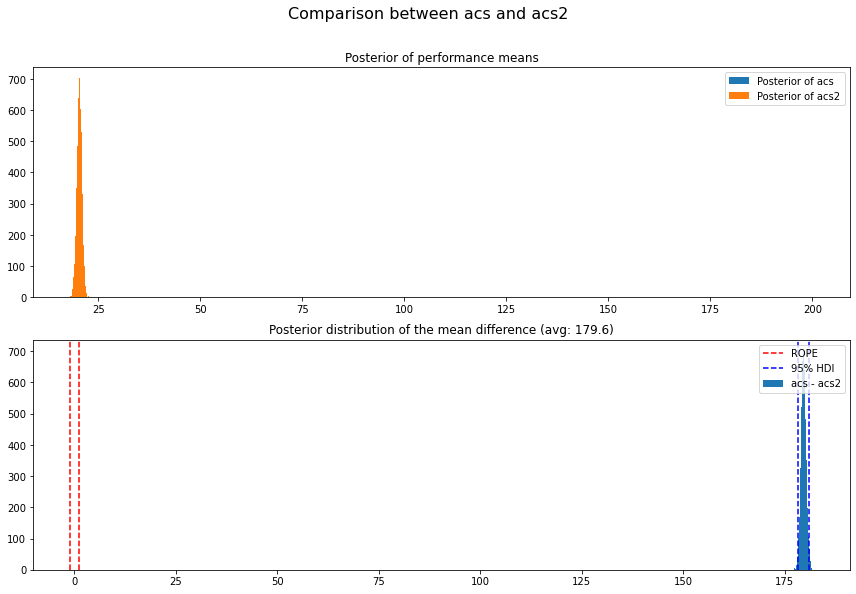

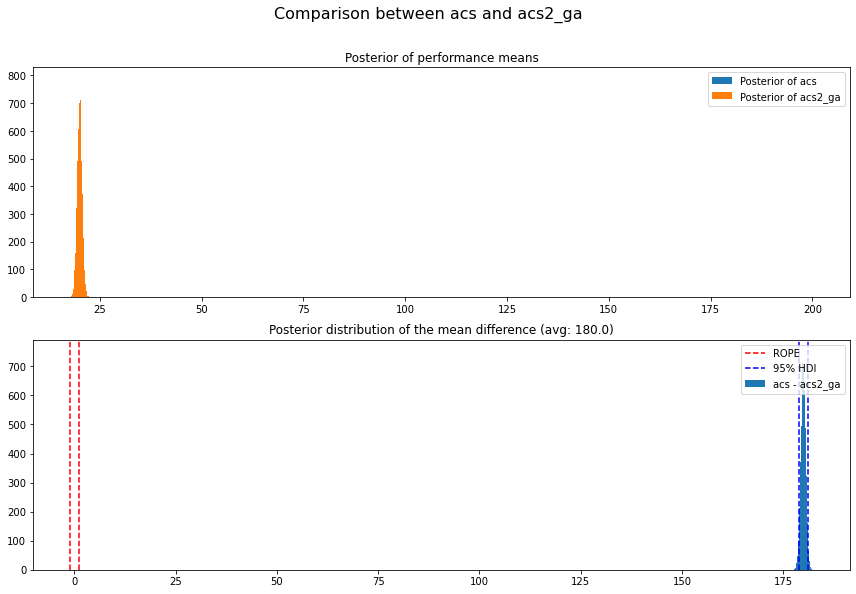

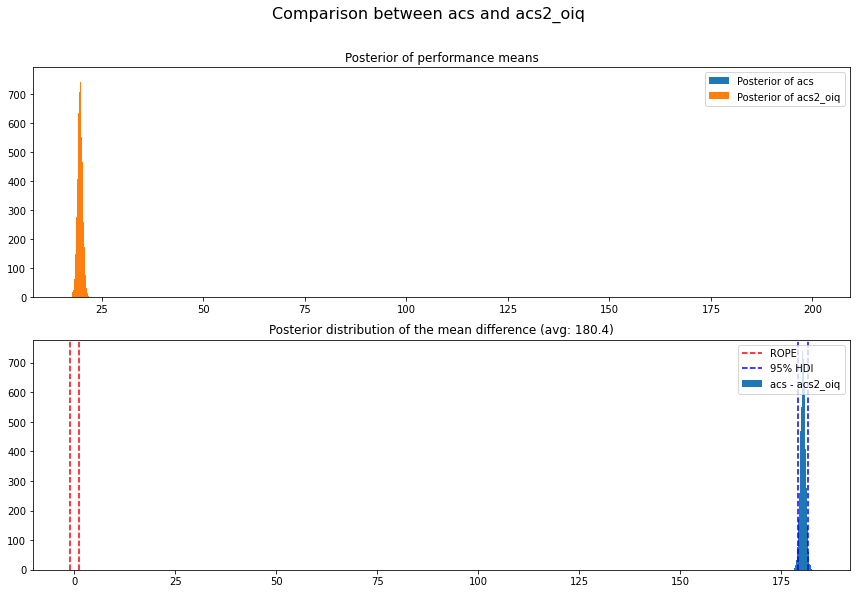

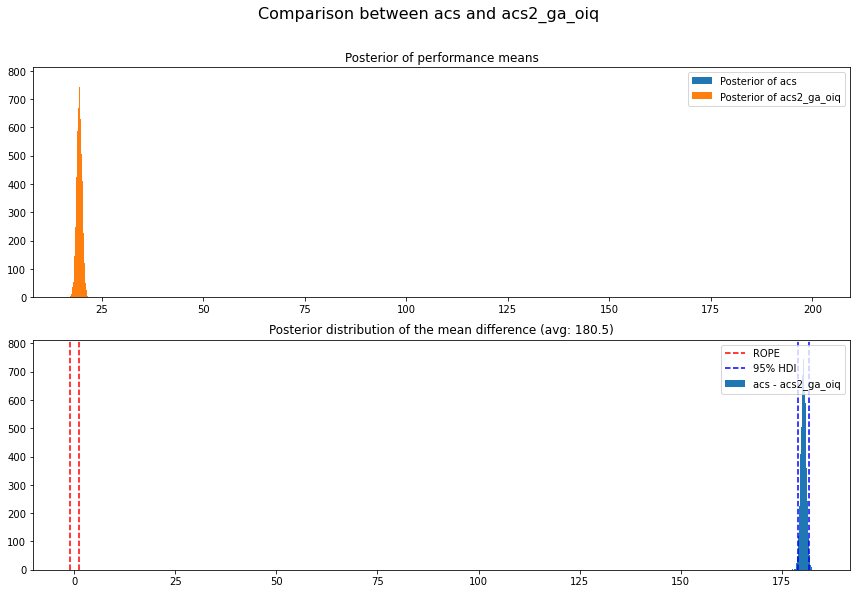

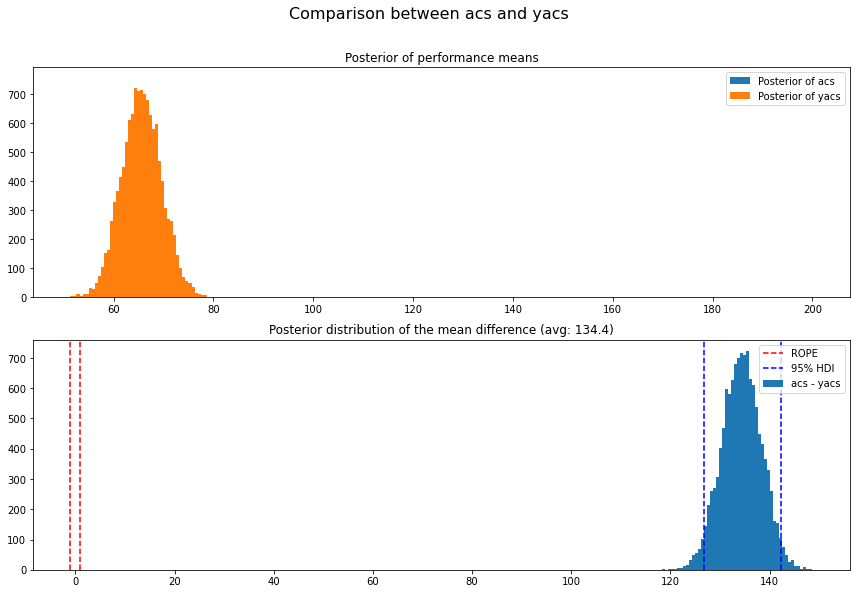

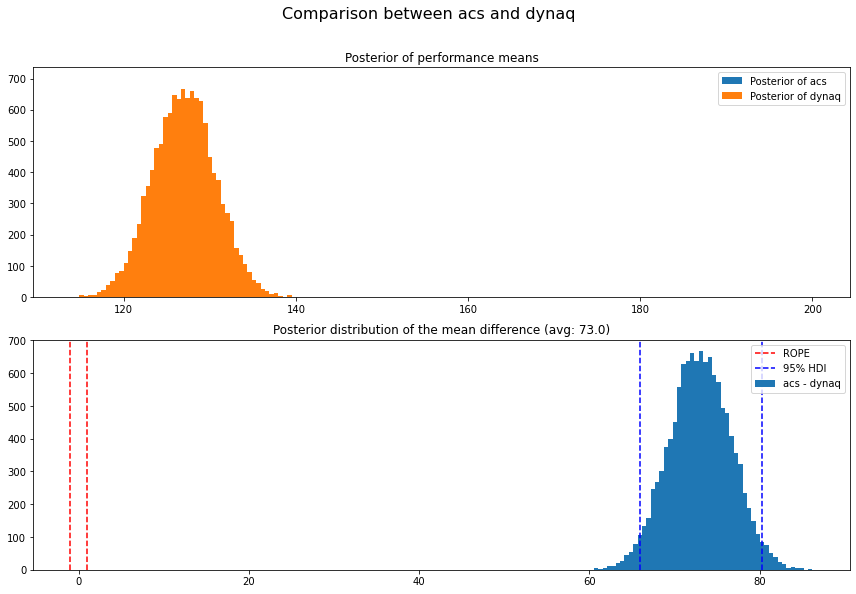

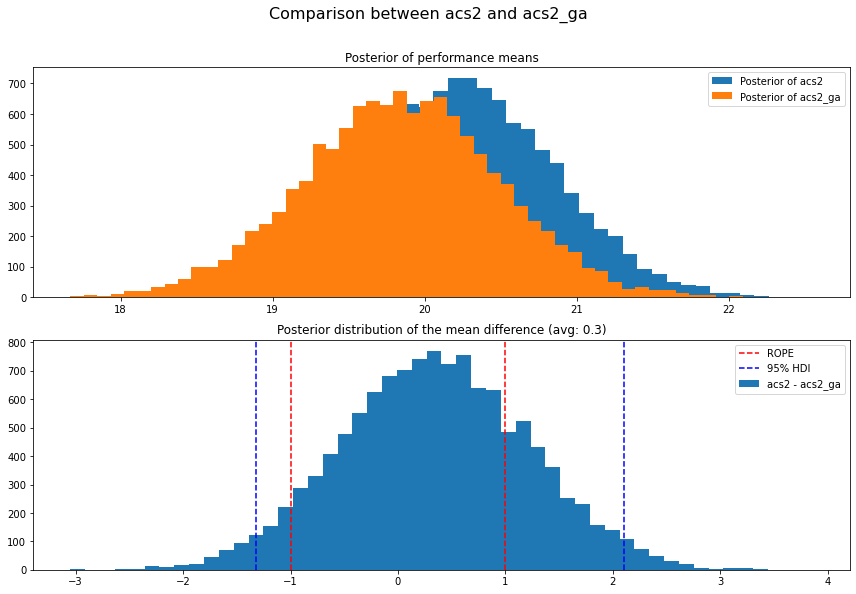

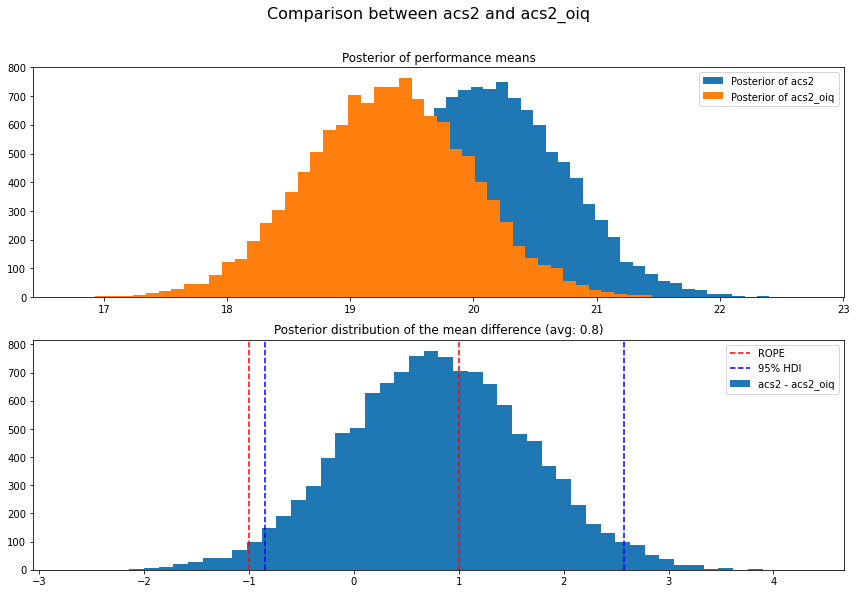

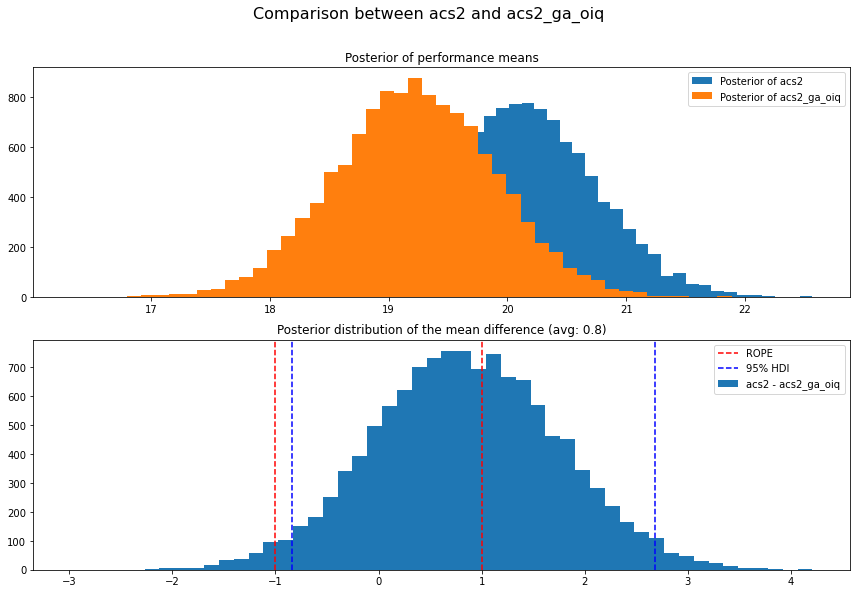

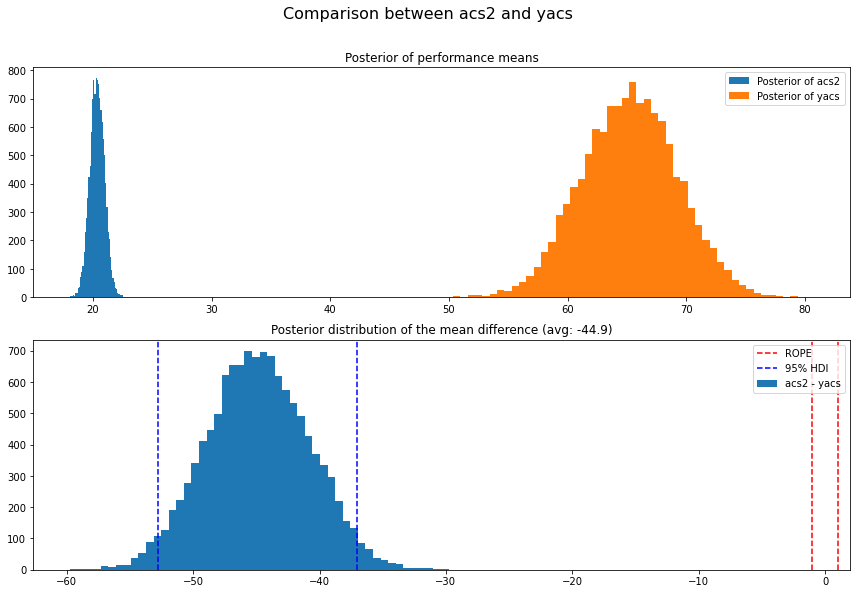

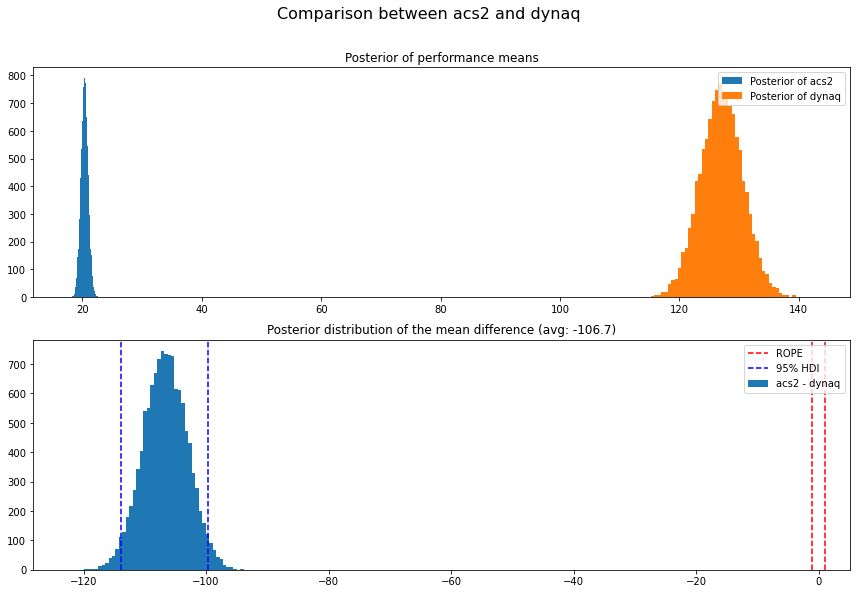

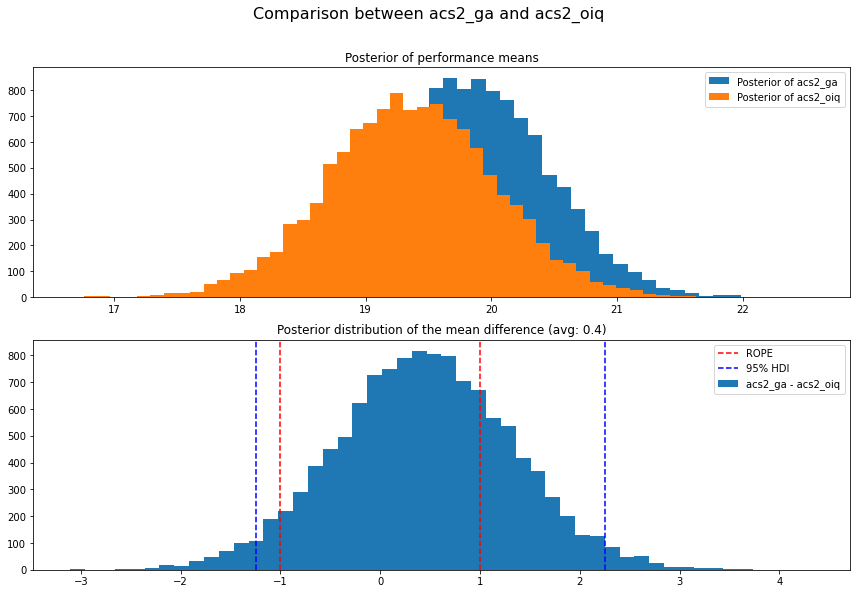

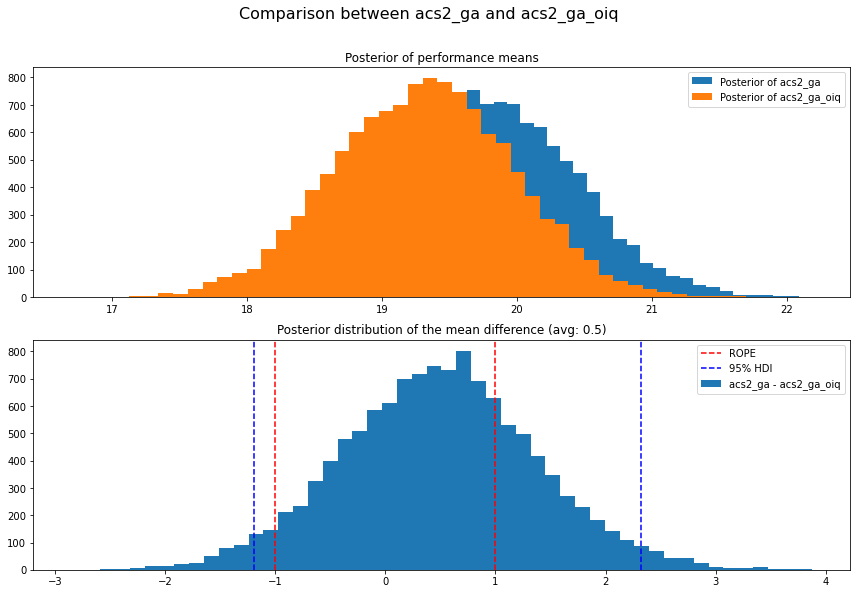

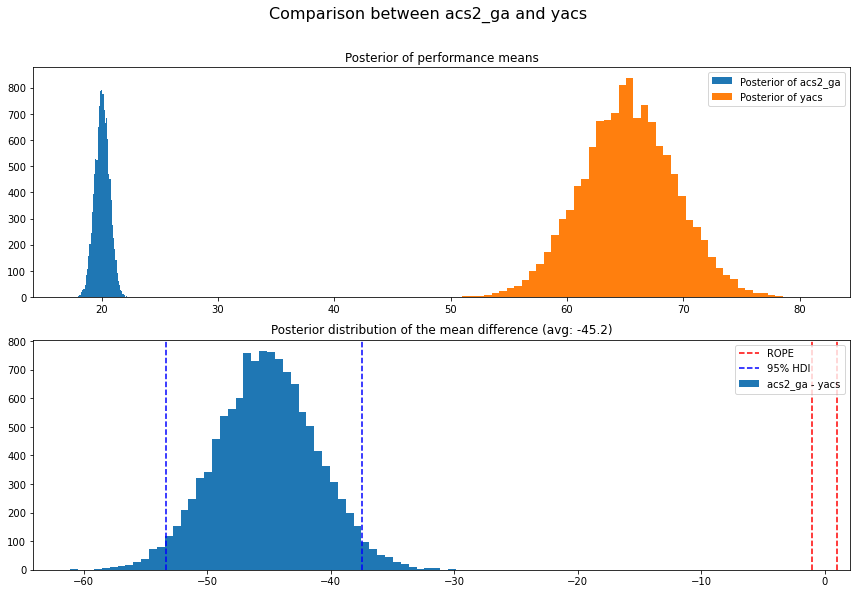

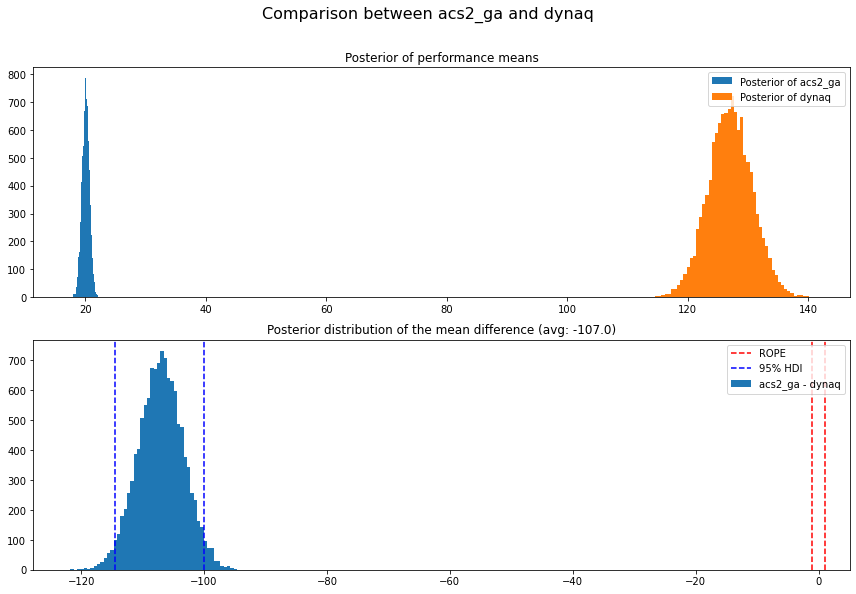

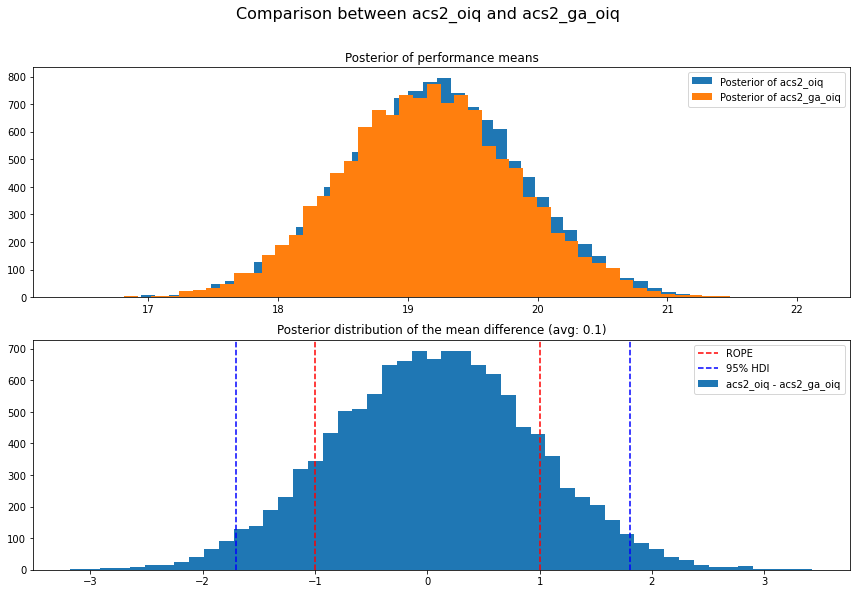

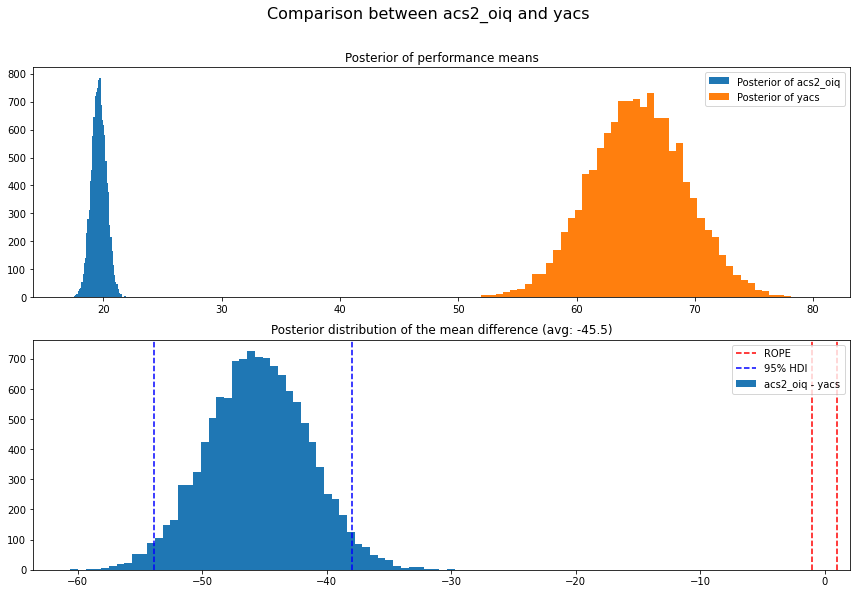

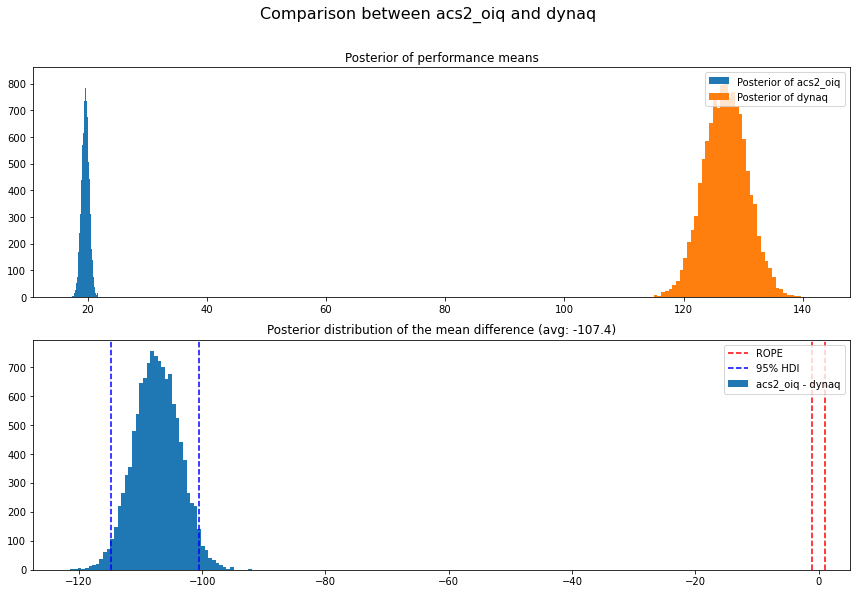

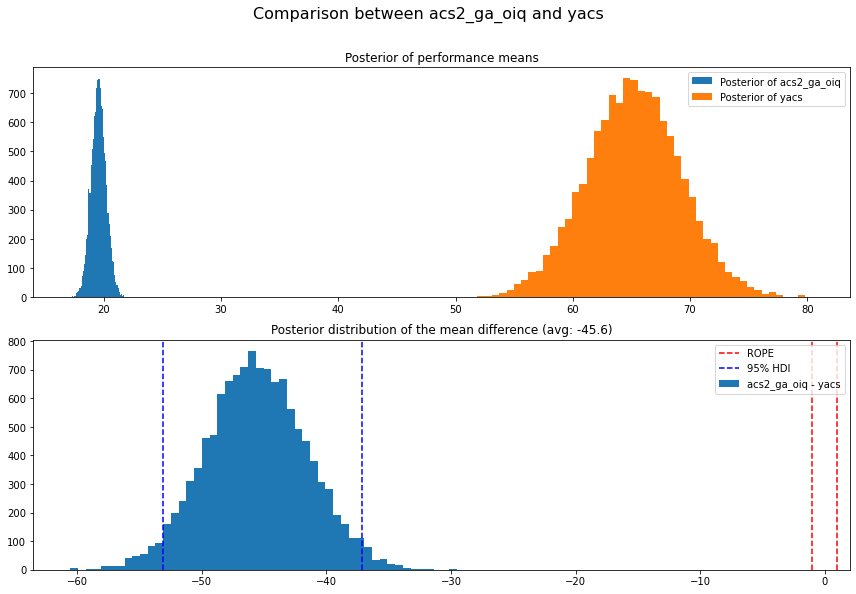

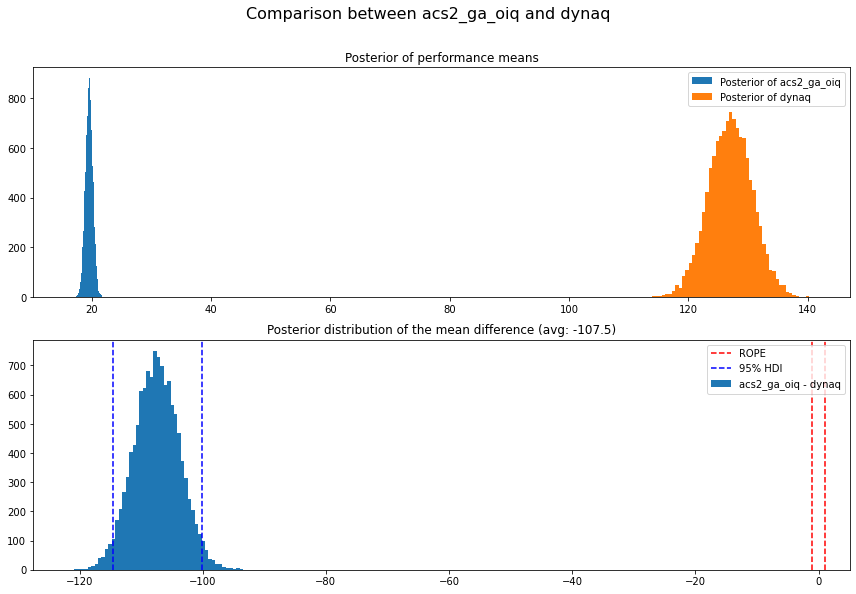

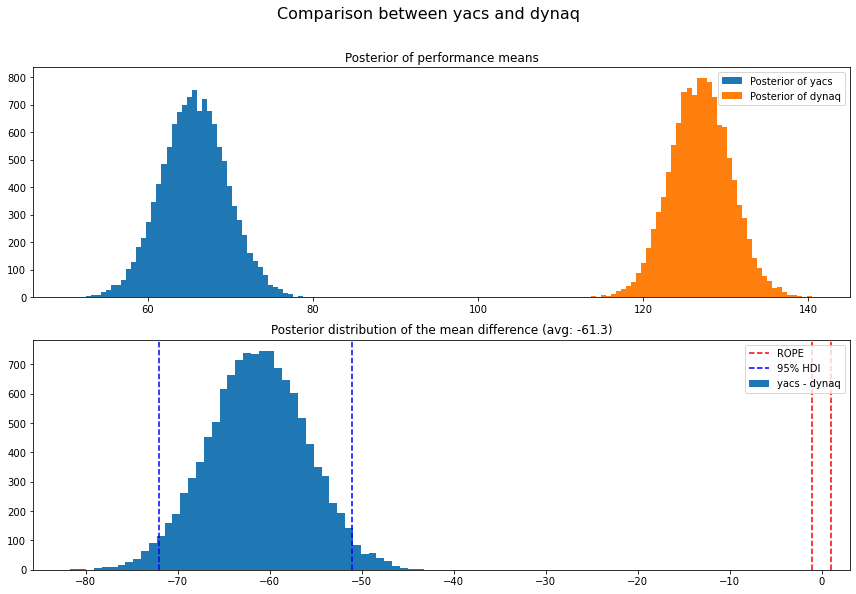

In [18]:
figsize(12, 12)
algs = ['acs', 'acs2', 'acs2_ga', 'acs2_oiq', 'acs2_ga_oiq', 'yacs', 'dynaq']

summary = []

for cl1, cl2 in itertools.combinations(algs, 2):
    trace = compare_two_classifiers(df, cl1, cl2)
    rope, hdi = visualize(trace, cl1, cl2)
    summary.append({
        'model1': cl1,
        'model2': cl2,
        'model1_avg_steps': trace['mu_1'].mean(),
        'model2_avg_steps': trace['mu_2'].mean(),
        'diff': trace['mu_1'].mean() - trace['mu_2'].mean(),
        'hdi_95': hdi,
        'h0': inference(rope, hdi)
    })

In [19]:
pd.DataFrame(summary)

,model1,model2,model1_avg_steps,model2_avg_steps,diff,hdi_95,h0
0,acs,acs2,199.999998,20.350653,179.649346,"[178.39603785178656, 180.8904391217094]",Null hypothesis rejected (HDI and ROPE are dis...
1,acs,acs2_ga,200.000000,20.033612,179.966389,"[178.78540068292114, 181.19557498384873]",Null hypothesis rejected (HDI and ROPE are dis...
2,acs,acs2_oiq,200.000001,19.614175,180.385826,"[179.15978698702818, 181.64311042175524]",Null hypothesis rejected (HDI and ROPE are dis...
3,acs,acs2_ga_oiq,200.000001,19.544480,180.455520,"[179.19570429719684, 181.72473200932427]",Null hypothesis rejected (HDI and ROPE are dis...
4,acs,yacs,200.000002,65.609031,134.390972,"[126.74775131832934, 142.27941796749394]",Null hypothesis rejected (HDI and ROPE are dis...
5,acs,dynaq,200.000009,127.002529,72.997480,"[65.98971828057384, 80.26638704926731]",Null hypothesis rejected (HDI and ROPE are dis...
6,acs2,acs2_ga,20.188972,19.842229,0.346742,"[-1.322124758636317, 2.1073365021638892]",Null hypothesis cannot be determined
7,acs2,acs2_oiq,20.094990,19.303910,0.791080,"[-0.8483143165416109, 2.5777469754456313]",Null hypothesis cannot be determined
8,acs2,acs2_ga_oiq,20.070617,19.221059,0.849558,"[-0.8364911497451466, 2.6855153435283796]",Null hypothesis cannot be determined
9,acs2,yacs,20.357312,65.223886,-44.866574,"[-52.73842116070861, -37.013923031140976]",Null hypothesis rejected (HDI and ROPE are dis...
